# Note on Gridworld Action Space Restriction
There is a problem, potentially, since staying in a location is not an allowable action (technically) but an agent could repeatedly choose an invalid action (if the invalid action is selectable in the first place). So I need to further prune the set of actions, depending on the state, but I do not want to do so in a way that is manual.

The way to do this is to count the number of non-corner edge states and account for that in the allowable set of actions. Since the area of the grid is length^2, the perimeter is 4$*$length, and the number of non-corner edge states is therefore 4$*$(length-1) and the number of corners is 4. Therefore, the number of allowable actions (dependent on state) is: $\left(4*{length}^2-4*length\right)*4+4*(length-1)*3+4*2$ so for $length=5$ we have $(100-20)*4+16*3+8=320+48+8=376$ actions.

<IPython.core.display.Javascript object>


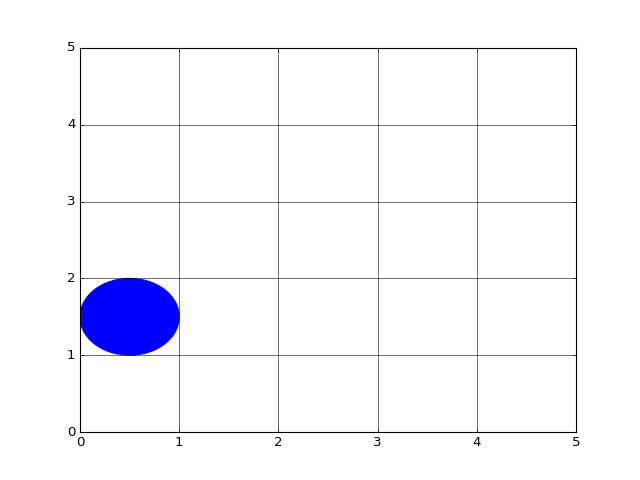

<IPython.core.display.Javascript object>


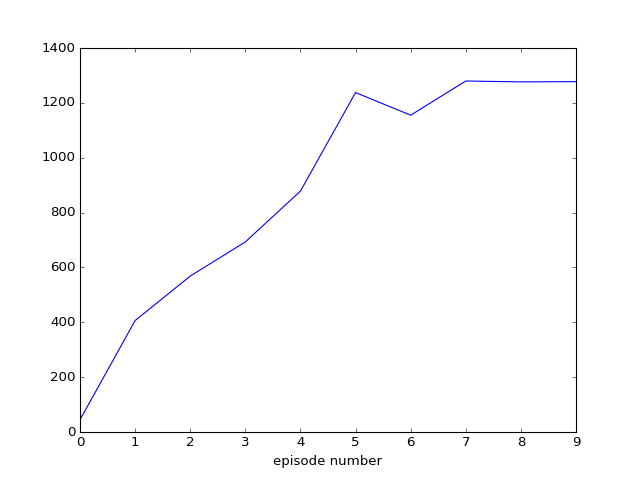

In [48]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import matplotlib.ticker as plticker

class gridworld(gym.Env):
  metadata = {'render.modes': ['human']}

  def __init__(self): 
    self.gridnum = int(5) #size of gridworld
    self.location_x = np.random.randint(int(0),self.gridnum)
    self.location_y = np.random.randint(int(0),self.gridnum)
    self.action = int(0) # no initial action until computed
    self.previous_action = self.action
    self.previous_x = self.location_x
    self.previous_y = self.location_y
    self.allowed_actions = np.array([int(0)])
    self.actionSet = np.matrix([1,2,3,4])
    self.episode_length = int(100)
    self.num_episodes = int(10) # currently only running one episode
    self.my_alpha = 0.3
    self.my_gamma = 0.9
    self.my_reward = np.matrix('3.3 8.8 4.4 5.4 1.5;1.5 3.0 2.3 1.9 0.5;0.1 0.7 0.7 0.4 -0.4; -1.0 -0.4 -0.4 -0.6 -1.2; -1.9 -1.3 -1.2 -1.4 -2.0') 
    self.my_reward_model = np.zeros([self.gridnum,self.gridnum])#reward model updated based on observations
    self.my_q_function = np.random.rand(self.gridnum,self.gridnum, int(4))# randomly initialized via reward model
    self.my_reward_log = np.random.rand(1, self.episode_length*self.num_episodes) # used to store reward for each time step
    self.my_episodic_cumulative_reward_log = np.random.rand(1,self.num_episodes)
    pass
  def get_allowed_actions(self):
    if self.location_x == 0 and self.location_y == 0:
        self.allowed_actions = np.array([1,4])[np.newaxis]
    elif self.location_x == 0 and self.location_y == self.gridnum - 1:
        self.allowed_actions = np.array([2,4])[np.newaxis]
    elif self.location_x == self.gridnum - 1 and self.location_y == 0:
        self.allowed_actions = np.array([1,3])[np.newaxis]
    elif self.location_x == self.gridnum - 1 and self.location_y == self.gridnum - 1:
        self.allowed_actions = np.array([2,3])[np.newaxis]
    elif self.location_x == 0:
        self.allowed_actions = np.array([1,2,4])[np.newaxis]
    elif self.location_x == self.gridnum - 1:
        self.allowed_actions = np.array([1,2,3])[np.newaxis]
    elif self.location_y == 0:
        self.allowed_actions = np.array([1,3,4])[np.newaxis]
    elif self.location_y == self.gridnum - 1:
        self.allowed_actions = np.array([2,3,4])[np.newaxis]
    else:
        self.allowed_actions = np.array([1,2,3,4])[np.newaxis]
    return self.allowed_actions 
    pass
  def my_policy(self):
    self.previous_action = self.action
    self.action = self.allowed_actions[0,np.argmax(self.my_q_function[self.location_x,self.location_y,self.allowed_actions-1])]
    if np.random.rand() <= 0.1:
        self.action = self.allowed_actions[0,np.random.randint(0,self.allowed_actions.shape[1])]
    # need epsilon greedy for exploration
    pass
  def step(self):
    self.previous_x = self.location_x
    self.previous_y = self.location_y
    desired_action = self.action
    if np.random.rand() <= 0.15: # this part of the method is to enforce a 10% chance of a random transition
        self.action = self.allowed_actions[0,np.random.randint(1,self.allowed_actions.shape[1])]
    if self.action == 1: # this part of the method is to select the desired deterministic action
        self.location_y += 1
    elif self.action == 2:
        self.location_y += -1
    elif self.action == 3:
        self.location_x += -1
    elif self.action == 4:
        self.location_x += 1
    self.action = desired_action
    pass #return [(self.location_x, self.location_y)]
  def update_reward_model(self):
    self.my_reward_model[self.location_x,self.location_y]\
    = self.my_reward[self.location_x,self.location_y]
    pass
  def update_my_q_function(self):#,action,location_x,location_y):
    self.my_q_function[self.previous_x,self.previous_y,self.previous_action-1] =\
    (1-self.alpha) * self.my_q_function[self.previous_x,self.previous_y,self.previous_action-1] +\
    self.alpha*(self.my_reward_model[self.location_x,self.location_y]+\
    self.gamma*self.my_q_function[self.location_x,self.location_y,self.best_action-1] )
    pass
  def reset(self):
    self.location_x = np.random.randint(int(0),self.gridnum)
    self.location_y = np.random.randint(int(0),self.gridnum)
    pass
  def render(self, mode='human', close=False):
    pass

world = gridworld()

fig, (ax)=plt.subplots()#do not know alternative to command fig.canvas.draw() to have independent subplots shown
fig1, (ax1)=plt.subplots()

intervals = float(1/world.gridnum)# 5x5 grid, dimension of grid affects size
loc = plticker.MultipleLocator(base=intervals)
ax.xaxis.set_major_locator(loc)
ax.set_xlim(0, world.gridnum)
ax.yaxis.set_major_locator(loc)
ax.set_ylim(0, world.gridnum)

ax.clear()
ax.grid(which='major', axis='both', linestyle='-')
circle2 = plt.Circle((world.location_x+0.5, world.location_y+0.5), 0.5, color='blue')#rand initialization
ax = fig.gca()
ax.add_artist(circle2)
fig.canvas.draw()

k=0 # counter for episodic cumulative reward
for i in range(0,world.episode_length * world.num_episodes - 1):
    world.my_reward_log[0,i] = world.my_reward[world.location_x,world.location_y]
    ax.clear()
    ax.grid(which='major', axis='both', linestyle='-')
    world.allowed_actions = world.get_allowed_actions()
    world.my_policy()
    world.step()
    circle2 = plt.Circle((world.location_x+0.5, world.location_y+0.5), 0.5, color='blue')
    ax = fig.gca()
    ax.add_artist(circle2)
    fig.canvas.draw()
    if np.mod(i+1,world.episode_length) == 0:
        world.my_episodic_cumulative_reward_log[0,k] = \
        np.sum(world.my_reward_log[0,\
        (k*world.episode_length):(i+1)])# sums from k*episode_length to i
#        (k*world.episode_length):((i+1)//world.episode_length+1)])
        k += 1
        world.reset()
ax1.plot(np.cumsum(world.my_episodic_cumulative_reward_log[0,:]))
plt.xlabel('episode number')
